In [2]:
import autorootcwd

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [4]:
from src.data import artificial
from src.evaluation import evaluate, search_knn, search_rf, search_xgboost

In [5]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


def generate_feature_subsets(X_train, y_train, num_features_list):
    feature_index_subsets = []
    selected_features = set()  # Store selected features across iterations

    for num_features in tqdm(num_features_list):
        cf = KNeighborsClassifier(n_neighbors=5)
        # cf = XGBClassifier()

        sfs1 = SFS(
            cf,
            k_features=num_features,
            forward=True,
            floating=True,
            verbose=0,
            scoring="balanced_accuracy",
            cv=5,
            n_jobs=-1,
            fixed_features=list(selected_features),
        )

        sfs1 = sfs1.fit(X_train, y_train)

        feature_index_subsets.append(sfs1.k_feature_idx_)

        # Update the selected features using the current iteration's selected features
        selected_features.update(sfs1.k_feature_idx_)

    return feature_index_subsets


In [5]:
X_artificial, y_artificial = artificial.prepare_data()
X_artificial.shape, y_artificial.shape

((2000, 500), (2000,))

In [6]:
num_features_list = [5, 6, 7, 8, 9, 10, 11]

feature_index_subsets = generate_feature_subsets(X_artificial, y_artificial, num_features_list)

100%|██████████| 8/8 [00:41<00:00,  5.20s/it]


In [7]:
for feature_indexes in feature_index_subsets:
    print(feature_indexes)

(48, 241, 318, 338, 455)
(48, 241, 318, 338, 433, 455)
(48, 241, 318, 338, 378, 433, 455)
(48, 241, 318, 338, 378, 433, 455, 472)
(48, 109, 241, 318, 338, 378, 433, 455, 472)
(48, 109, 241, 318, 338, 378, 433, 455, 472, 485)
(48, 109, 241, 318, 338, 378, 433, 451, 455, 472, 485)
(48, 109, 163, 241, 318, 338, 378, 433, 451, 455, 472, 485)


In [8]:
hist_knn = []
hist_rf = []
hist_xgb = []

for feature_indexes in feature_index_subsets:
    X_train = X_artificial[:, feature_indexes]
    y_train = y_artificial
    
    params_knn, _ = search_knn(X_train, y_train, verbose=0)
    params_rf, _ = search_rf(X_train, y_train, verbose=0)
    params_xgb, _ = search_xgboost(X_train, y_train, verbose=0)
    
    scores = evaluate(X_train, y_train, num_folds=10, scoring_coefficient=0.2, params_knn=params_knn, params_rf=params_rf, params_xgb=params_xgb)
    print(params_knn)
    print(params_rf) 
    print(params_xgb)
    print("num features:", len(feature_indexes))
    print("scores:", scores)
    print("---")
    
    hist_knn.append((len(feature_indexes), scores["KNN"][1]))
    hist_rf.append((len(feature_indexes), scores["RF"][1]))
    hist_xgb.append((len(feature_indexes), scores["XGB"][1]))

{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
{'n_estimators': 400}
{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 300}
num features: 5
scores: {'KNN': (0.879, 0.879), 'RF': (0.8495, 0.8495), 'XGB': (0.839, 0.839)}
---
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
{'n_estimators': 400}
{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 300}
num features: 6
scores: {'KNN': (0.878, 0.876), 'RF': (0.8685, 0.8665), 'XGB': (0.8485, 0.8465)}
---
{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}
{'n_estimators': 200}
{'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 400}
num features: 7
scores: {'KNN': (0.8885, 0.8845), 'RF': (0.866, 0.862), 'XGB': (0.8605, 0.8565)}
---
{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
{'n_estimators': 400}
{'learning_rate': 0.01, 'max_depth': 11, 'n_estimators': 400}
num features: 8
scores: {'KNN': (0.8945, 0.8885), 'RF': (0.878, 0.872), 'XGB': (0.862, 0.856)}
---
{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
{'n_estimators': 3

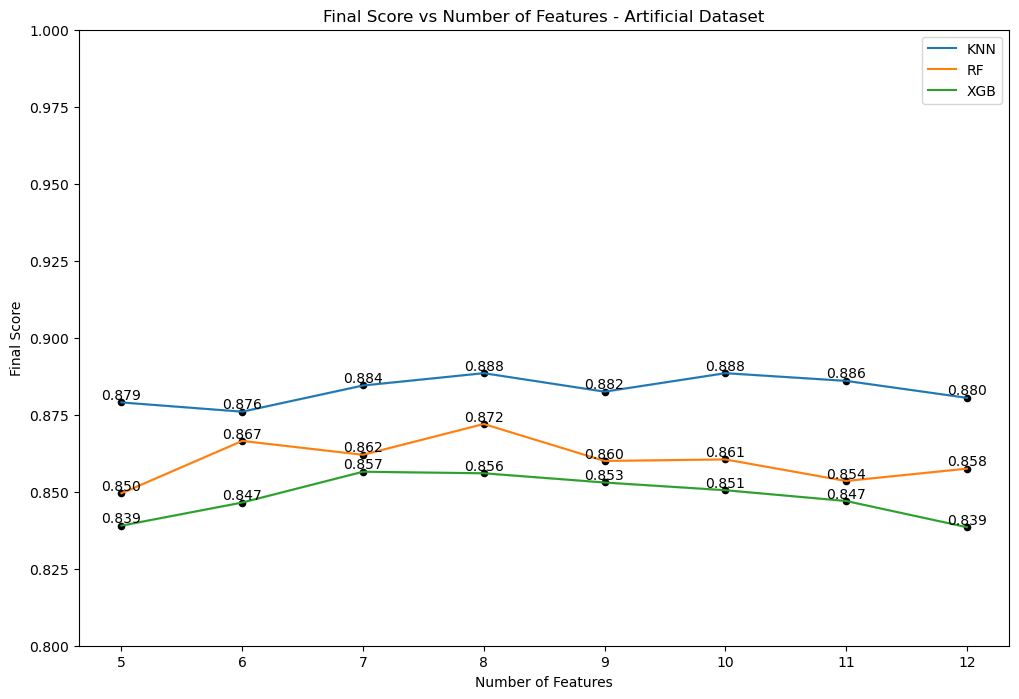

In [9]:
plt.figure(figsize=(12, 8))
plt.title("Final Score vs Number of Features - Artificial Dataset")
plt.xlabel("Number of Features")
plt.ylabel("Final Score")
plt.ylim((0.8, 1.0))

df_knn = pd.DataFrame(hist_knn, columns=["num_features", "knn"])
df_rf = pd.DataFrame(hist_rf, columns=["num_features", "rf"])
df_xgb = pd.DataFrame(hist_xgb, columns=["num_features", "xgb"])

df_knn["model"] = "KNN"
df_rf["model"] = "RF"
df_xgb["model"] = "XGB"

df = pd.concat([df_knn, df_rf, df_xgb])

sns.lineplot(data=df, x="num_features", y="knn", label="KNN")
sns.lineplot(data=df, x="num_features", y="rf", label="RF")
sns.lineplot(data=df, x="num_features", y="xgb", label="XGB")

# Add dots and numbers
for _, row in df.iterrows():
    plt.scatter(row["num_features"], row[row["model"].lower()], color="black", s=20)
    plt.text(row["num_features"], row[row["model"].lower()], f"{row[row['model'].lower()]:.3f}", 
             ha="center", va="bottom", fontsize=10)

plt.legend()
plt.savefig("artificial_sffs.png")
plt.show()

In [10]:
import pandas as pd

data = [
    {"dataset_name": "artificial", "feature_selection_method": "sffs", "classifier":"KNN", "best_num_features": 8, "best_score": 0.888},
    {"dataset_name": "spam", "feature_selection_method": "sffs", "classifier":"KNN", "best_num_features": "-", "best_score": "-"}
]

df = pd.DataFrame(data, columns=["dataset_name", "feature_selection_method", "classifier", "best_num_features", "best_score"])
df.to_csv("results/sffs_results.csv", index=False)